# Data-Driven Pricing: Enhancing Online Car Sales Using Predictive Analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from read_data import read_data
import re

sns.set_theme(color_codes=True)


### problem statement
The e-commerce sector is witnessing remarkable expansion, particularly in online selling. \ 

In this project, we are required to contribute to this growth by constructing a comprehensive data warehouse capable of efficiently storing historical operational data for an online car selling business. You will also need to extract actionable business insights from this rich dataset.
Additionally, you will implement a machine learning solution for predicting car prices taking into account various features of the vehicle, as well as temporal factors.


In [2]:
df = read_data('data/Sales.csv')
df.head()

,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
0,1,2011-04-04 13:38:56,sedan,Automatic,gasoline,NaN,397,bmw,"150,000km",286,1992,"96,600,000 Rwf"
1,2,2011-03-12 16:58:10,compact car,Automatic,gasoline,NaN,240,smart,"70,000km",71,2002,"48,420,000 Rwf"
2,3,2011-04-01 14:38:50,station wagon,Manual,gasoline,NaN,226,ford,"150,000km",0,1998,"12,420,000 Rwf"
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,NaN,111,volkswagen,"150,000km",90,1990,"360,000 Rwf"
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,NaN,861,volkswagen,"150,000km",90,1993,"13,188,000 Rwf"


In [3]:
df_sellers = read_data('data/Sellers.csv')
df_sellers.head()

,seller_id,first_name,last_name,email,year of birth,country_of_origin
0,1,Brendan,Hernandez,rushdanielle@example.net,1948,Comoros
1,2,Jonathan,Harris,brittany88@example.org,1946,Belarus
2,3,Jimmy,Logan,howellrhonda@example.net,1985,Cambodia
3,4,Keith,Davis,kennethpeterson@example.org,1950,Canada
4,5,Jack,Fisher,tsmith@example.com,1994,Brazil


In [4]:
df_dates = read_data('data/Dates.csv')
df_dates.head()

,Day,Season,Month,Holiday,Week Day,Working Day
0,2011-01-01,Winter,1,No,6,No
1,2011-01-02,Winter,1,No,0,No
2,2011-01-03,Winter,1,No,1,Yes
3,2011-01-04,Winter,1,No,2,Yes
4,2011-01-05,Winter,1,No,3,Yes


# 1. Data prepocessing

In [5]:
print("Sales data shape:",df.shape)
print("Sellers data shape:",df_sellers.shape)
print("Dates data shape:",df_dates.shape)

Sales data shape: (31814, 12)
Sellers data shape: (977, 6)
Dates data shape: (365, 6)


In [6]:
df['id'].nunique()

31814

Seing the those unique values, the ids are unique in all the sales data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31814 entries, 0 to 31813
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 31814 non-null  int64 
 1   selling_date       31814 non-null  object
 2   vehicle_type       28450 non-null  object
 3   transmission_type  30053 non-null  object
 4   fuel_type          28909 non-null  object
 5   repaired           3077 non-null   object
 6   seller             31814 non-null  int64 
 7   brand              31814 non-null  object
 8   odometer           31814 non-null  object
 9   horse_power        31814 non-null  int64 
 10  manufactured_date  31814 non-null  int64 
 11  price              31814 non-null  object
dtypes: int64(4), object(8)
memory usage: 2.9+ MB


> Transmission type is clean\
> Vehicle type is clear only other need more to understand\
> Price need to be converted and remove rwf and column(,)\
> Fuel type is clean, only other need to be determine if is important\
> Odometer need to remove the kilometer(km) and column(,)\
> Repaired need to converted into boolean and replace NaN with No\
> Manufactured date  need to be clean an remove non conventional date
> Horse power of car which can not have some horse power so we need to remove them, outliers basicaly, and how come a car can do 0 km????


In [10]:
# Price need to be converted and remove rwf and column(,)\

df['price'] = df['price'].str.replace(',', '').replace(r'(?i)\s*rwf','', regex=True).astype(float)
df['price']


0         96600000.0
1         48420000.0
2         12420000.0
3           360000.0
4         13188000.0
            ...     
31809     49198800.0
31810       480000.0
31811            0.0
31812    181080000.0
31813     13176000.0
Name: price, Length: 31814, dtype: float64

In [12]:
# Odometer need to remove the kilometer(km) and column(,)
df['odometer'] = df['odometer'].str.replace(',', '').replace(r'(?i)\s*km','', regex=True).astype(float)
df['odometer']


0        150000.0
1         70000.0
2        150000.0
3        150000.0
4        150000.0
           ...   
31809    150000.0
31810    125000.0
31811    150000.0
31812    125000.0
31813    150000.0
Name: odometer, Length: 31814, dtype: float64

In [13]:
# Repaired need to converted into boolean and replace NaN with No\
df['repaired'] = df['repaired'].replace({'Yes': True}).fillna(False)
df['repaired'].value_counts()

repaired
False    28737
True      3077
Name: count, dtype: int64

In [14]:
#Manufactured date  need to be clean an remove non conventional date
df['selling_date'] = pd.to_datetime(df['selling_date'])
df['selling_date'].tail()

31809   2011-03-12 11:50:17
31810   2011-03-12 10:55:54
31811   2011-03-31 22:48:48
31812   2011-04-04 20:46:02
31813   2011-03-28 10:50:25
Name: selling_date, dtype: datetime64[ns]

In [15]:
#remove non conventional date

def filter_by_year_range(df, column_name, start_year, end_year):
    
    # Convert the date column to datetime if it's not already
    df[column_name] = df[column_name].astype(str)

    # Filter rows based on the year range
    filtered_df = df[(df[column_name].str[:4].astype(int) >= start_year) & (df[column_name].str[:4].astype(int) <= end_year)]

    return filtered_df



In [16]:
df = filter_by_year_range(df, 'manufactured_date', 1886, 2024)
df



,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
0,1,2011-04-04 13:38:56,sedan,Automatic,gasoline,False,397,bmw,150000.0,286,1992,96600000.0
1,2,2011-03-12 16:58:10,compact car,Automatic,gasoline,False,240,smart,70000.0,71,2002,48420000.0
2,3,2011-04-01 14:38:50,station wagon,Manual,gasoline,False,226,ford,150000.0,0,1998,12420000.0
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,False,111,volkswagen,150000.0,90,1990,360000.0
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0
31810,31811,2011-03-12 10:55:54,station wagon,Manual,gasoline,False,253,ford,125000.0,105,1990,480000.0
31811,31812,2011-03-31 22:48:48,NaN,NaN,NaN,False,243,sonstige_autos,150000.0,0,1995,0.0
31812,31813,2011-04-04 20:46:02,sedan,Automatic,diesel,False,32,chrysler,125000.0,218,2005,181080000.0


In [ ]:
# Horse power of car which can not have some horse power so we need to remove them, outliers basicaly, and how come a car can do 0 km????


In [ ]:
# # Plot categorical data
# sales_vars = ['transmission_type', 'vehicle_type', 'fuel_type', 'repaired', 'brand']

# # Create figure with subplots
# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
# axs = axs.flatten()

# for i, var in enumerate(sales_vars):
#     sns.barplot(x=var, data=df, ax=axs[i])
#     axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
#     axs[i].set_title(var.replace("_", " ").capitalize())
    
    
# if len(sales_vars) < 6:
#     fig.delaxes(axs[-1])
    
# fig.tight_layout()
# plt.show()



In [17]:
def filter_outliers(df, column):
    
    # Calculate the interquartile range (IQR)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter rows to remove outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return filtered_df

In [18]:
# df = filter_outliers(df, 'horse_power')
# df


,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
1,2,2011-03-12 16:58:10,compact car,Automatic,gasoline,False,240,smart,70000.0,71,2002,48420000.0
2,3,2011-04-01 14:38:50,station wagon,Manual,gasoline,False,226,ford,150000.0,0,1998,12420000.0
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,False,111,volkswagen,150000.0,90,1990,360000.0
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0
31810,31811,2011-03-12 10:55:54,station wagon,Manual,gasoline,False,253,ford,125000.0,105,1990,480000.0
31811,31812,2011-03-31 22:48:48,NaN,NaN,NaN,False,243,sonstige_autos,150000.0,0,1995,0.0
31812,31813,2011-04-04 20:46:02,sedan,Automatic,diesel,False,32,chrysler,125000.0,218,2005,181080000.0


In [19]:
# df = filter_outliers(df, 'odometer')
# df


,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
2,3,2011-04-01 14:38:50,station wagon,Manual,gasoline,False,226,ford,150000.0,0,1998,12420000.0
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,False,111,volkswagen,150000.0,90,1990,360000.0
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
6,7,2011-03-16 14:59:02,station wagon,Manual,gasoline,False,255,opel,150000.0,101,1994,420000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0
31810,31811,2011-03-12 10:55:54,station wagon,Manual,gasoline,False,253,ford,125000.0,105,1990,480000.0
31811,31812,2011-03-31 22:48:48,NaN,NaN,NaN,False,243,sonstige_autos,150000.0,0,1995,0.0
31812,31813,2011-04-04 20:46:02,sedan,Automatic,diesel,False,32,chrysler,125000.0,218,2005,181080000.0


<Axes: >

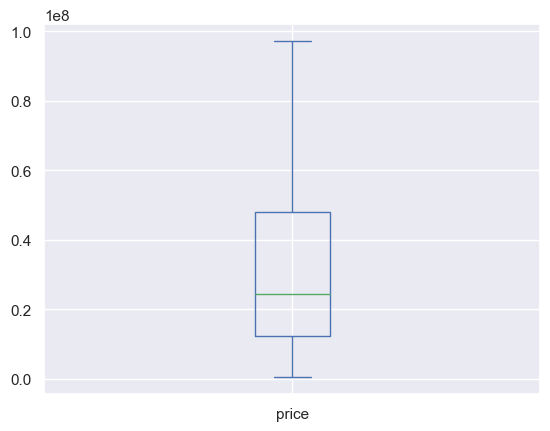

In [37]:
# df['price'].plot(kind='box')

In [34]:
# df = filter_outliers(df, 'price')
# df

,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
7,8,2011-03-29 11:46:22,Other,Manual,gasoline,False,809,volkswagen,150000.0,205,1985,60600000.0
10,11,2011-03-10 19:55:34,van,Manual,diesel,False,213,peugeot,150000.0,120,2005,85198800.0
12,13,2011-04-02 12:45:44,station wagon,Automatic,diesel,False,886,mercedes_benz,150000.0,204,1999,49198800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31803,31804,2011-03-05 18:52:14,sedan,Manual,gasoline,True,62,opel,150000.0,75,1979,720000.0
31805,31806,2011-03-10 10:52:01,Other,Manual,LPG,False,412,bmw,150000.0,150,1995,25080000.0
31806,31807,2011-03-14 17:57:15,sedan,Manual,gasoline,True,619,mitsubishi,150000.0,82,1999,24240000.0
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0


In [23]:
def remove_columns_with_empty_or_zeros(dataset, threshold=5):
   
    # Count the number of empty or NaN values and zeros in each column
    empty_or_zero_count = dataset.isnull().sum(axis=1) + (dataset == 0).sum(axis=1)

    # Filter rows based on the maximum number of empty or zero values allowed
    filtered_df = df[empty_or_zero_count <= threshold]

    return filtered_df

In [24]:
df = remove_columns_with_empty_or_zeros(df)
df

,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
2,3,2011-04-01 14:38:50,station wagon,Manual,gasoline,False,226,ford,150000.0,0,1998,12420000.0
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,False,111,volkswagen,150000.0,90,1990,360000.0
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
6,7,2011-03-16 14:59:02,station wagon,Manual,gasoline,False,255,opel,150000.0,101,1994,420000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31806,31807,2011-03-14 17:57:15,sedan,Manual,gasoline,True,619,mitsubishi,150000.0,82,1999,24240000.0
31808,31809,2011-03-11 10:53:51,sedan,Manual,gasoline,False,823,opel,125000.0,116,2006,72840000.0
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0
31810,31811,2011-03-12 10:55:54,station wagon,Manual,gasoline,False,253,ford,125000.0,105,1990,480000.0


In [26]:
df = df.dropna()
df

,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
2,3,2011-04-01 14:38:50,station wagon,Manual,gasoline,False,226,ford,150000.0,0,1998,12420000.0
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,False,111,volkswagen,150000.0,90,1990,360000.0
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
6,7,2011-03-16 14:59:02,station wagon,Manual,gasoline,False,255,opel,150000.0,101,1994,420000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31806,31807,2011-03-14 17:57:15,sedan,Manual,gasoline,True,619,mitsubishi,150000.0,82,1999,24240000.0
31808,31809,2011-03-11 10:53:51,sedan,Manual,gasoline,False,823,opel,125000.0,116,2006,72840000.0
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0
31810,31811,2011-03-12 10:55:54,station wagon,Manual,gasoline,False,253,ford,125000.0,105,1990,480000.0


In [27]:
# df = df[df['price'] != 0]
# df

,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
2,3,2011-04-01 14:38:50,station wagon,Manual,gasoline,False,226,ford,150000.0,0,1998,12420000.0
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,False,111,volkswagen,150000.0,90,1990,360000.0
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
6,7,2011-03-16 14:59:02,station wagon,Manual,gasoline,False,255,opel,150000.0,101,1994,420000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31806,31807,2011-03-14 17:57:15,sedan,Manual,gasoline,True,619,mitsubishi,150000.0,82,1999,24240000.0
31808,31809,2011-03-11 10:53:51,sedan,Manual,gasoline,False,823,opel,125000.0,116,2006,72840000.0
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0
31810,31811,2011-03-12 10:55:54,station wagon,Manual,gasoline,False,253,ford,125000.0,105,1990,480000.0


In [28]:
df = df[df['horse_power'] >= 50]
df

,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
3,4,2011-03-20 17:55:21,sedan,Manual,gasoline,False,111,volkswagen,150000.0,90,1990,360000.0
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
6,7,2011-03-16 14:59:02,station wagon,Manual,gasoline,False,255,opel,150000.0,101,1994,420000.0
7,8,2011-03-29 11:46:22,Other,Manual,gasoline,False,809,volkswagen,150000.0,205,1985,60600000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31806,31807,2011-03-14 17:57:15,sedan,Manual,gasoline,True,619,mitsubishi,150000.0,82,1999,24240000.0
31808,31809,2011-03-11 10:53:51,sedan,Manual,gasoline,False,823,opel,125000.0,116,2006,72840000.0
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0
31810,31811,2011-03-12 10:55:54,station wagon,Manual,gasoline,False,253,ford,125000.0,105,1990,480000.0


In [30]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,17551.0,15825.84753,4.0,7865.5,15789.0,23810.0,31814.0,9184.868499
selling_date,17551,2011-03-21 12:59:48.204888576,2011-03-05 14:06:30,2011-03-13 05:36:21.500000,2011-03-21 16:53:12,2011-03-29 15:46:16.500000,2011-04-07 14:30:26,NaN
seller,17551.0,426.282605,1.0,173.0,397.0,663.0,977.0,284.051906
odometer,17551.0,142432.340038,90000.0,150000.0,150000.0,150000.0,150000.0,16257.478496
horse_power,17551.0,115.776594,50.0,80.0,110.0,143.0,260.0,43.167365
price,17551.0,34772640.875164,1200.0,12240000.0,24600000.0,49140000.0,132432000.0,32562468.850038


In [38]:
df =df[(df['price'] > 500000) & (df['odometer'] == 150000.0)]
df

,id,selling_date,vehicle_type,transmission_type,fuel_type,repaired,seller,brand,odometer,horse_power,manufactured_date,price
4,5,2011-03-16 18:55:19,sedan,Manual,diesel,False,861,volkswagen,150000.0,90,1993,13188000.0
5,6,2011-03-23 10:48:32,sedan,Manual,gasoline,False,543,audi,150000.0,101,1994,12420000.0
7,8,2011-03-29 11:46:22,Other,Manual,gasoline,False,809,volkswagen,150000.0,205,1985,60600000.0
10,11,2011-03-10 19:55:34,van,Manual,diesel,False,213,peugeot,150000.0,120,2005,85198800.0
12,13,2011-04-02 12:45:44,station wagon,Automatic,diesel,False,886,mercedes_benz,150000.0,204,1999,49198800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31803,31804,2011-03-05 18:52:14,sedan,Manual,gasoline,True,62,opel,150000.0,75,1979,720000.0
31805,31806,2011-03-10 10:52:01,Other,Manual,LPG,False,412,bmw,150000.0,150,1995,25080000.0
31806,31807,2011-03-14 17:57:15,sedan,Manual,gasoline,True,619,mitsubishi,150000.0,82,1999,24240000.0
31809,31810,2011-03-12 11:50:17,station wagon,Manual,diesel,False,483,volkswagen,150000.0,140,2001,49198800.0


In [ ]:
plt.figure(figsize=(14,12))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values in Sales Data')
plt.show()